## Analysis of an E-commerce Dataset 

In [ ]:
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
import matplotlib.pylab as plt
%matplotlib inline


ecom_data = pd.read_csv('files/ecom_dataset.csv')
print(f'The length of the dataset is {len(ecom_data)}')

In [74]:
#using head() 
ecom_data.head()

,userId,timestamp,review,item,rating,helpfulness,gender,category,item_id,item_price,user_city
0,4081,71900,Not always McCrap,McDonald's,4.0,3.0,M,Restaurants & Gourmet,41,30.74,4
1,4081,72000,I dropped the chalupa even before he told me to,Taco Bell,1.0,4.0,M,Restaurants & Gourmet,74,108.30,4
2,4081,72000,The Wonderful World of Wendy,Wendy's,5.0,4.0,M,Restaurants & Gourmet,84,69.00,4
3,4081,100399,They actually did it,"South Park: Bigger, Longer & Uncut",5.0,3.0,M,Movies,68,143.11,4
4,4081,100399,Hey! Gimme some pie!,American Pie,3.0,3.0,M,Movies,6,117.89,4


In [75]:
#using info()
ecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2685 entries, 0 to 2684
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   userId       2685 non-null   int64  
 1   timestamp    2685 non-null   int64  
 2   review       2685 non-null   object 
 3   item         2685 non-null   object 
 4   rating       2685 non-null   float64
 5   helpfulness  2685 non-null   float64
 6   gender       2685 non-null   object 
 7   category     2685 non-null   object 
 8   item_id      2685 non-null   int64  
 9   item_price   2685 non-null   float64
 10  user_city    2685 non-null   int64  
dtypes: float64(3), int64(4), object(4)
memory usage: 230.9+ KB


In [78]:
#correlations between helpfulness/gender/category/review
ord_encoder = OrdinalEncoder()
feat_col = ['gender','category','review']
ecom_data[feat_col] = ord_encoder.fit_transform(ecom_data[feat_col])
corr_values = ecom_data[['helpfulness','gender','category','review','rating']].corr()
corr_values


,helpfulness,gender,category,review,rating
helpfulness,1.000000,0.075947,-0.013408,-0.028259,-0.007523
gender,0.075947,1.000000,0.022549,-0.037884,-0.034337
category,-0.013408,0.022549,1.000000,0.001970,-0.163158
review,-0.028259,-0.037884,0.001970,1.000000,-0.036118
rating,-0.007523,-0.034337,-0.163158,-0.036118,1.000000


## Correlation analysis and hypothesis

From the above correlation matrix, it can be seen that category and review have the most correlation with rating whereas gender and helpfulness have the least correlation. All of the columns have a negative correlation with rating. 

Since the most correlated values are better predictors, we can assume that in the following experiment, models with category and review as the features will outperform models with gender and helpfulness. 

This can then be verified later by evaluating the errors values of the predictions.

### Split Training and Testing Data
* Machine learning models are trained to help make predictions for the future. Normally, we need to randomly split the dataset into training and testing sets, where we use the training set to train the model, and then leverage the well-trained model to make predictions on the testing set.
* To further investigate whether the size of the training/testing data affects the model performance, we randomly split the data into training and testing sets with different sizes:
    * Case 1: training data containing 10% of the entire data;
    * Case 2: training data containing 90% of the entire data.


In [79]:
#dropping all other rows besides gender, category and review
ecom_data.drop(['userId','timestamp','item','item_id','item_price','user_city'], axis = 1, inplace = True)
ecom_data.head()

,review,rating,helpfulness,gender,category
0,1618.0,4.0,3.0,1.0,8.0
1,1125.0,1.0,4.0,1.0,8.0
2,2185.0,5.0,4.0,1.0,8.0
3,2243.0,5.0,3.0,1.0,5.0
4,1033.0,3.0,3.0,1.0,5.0


In [81]:
#case 1: training data containing 10% of the entire data
train_c1_data, test_c1_data = train_test_split(ecom_data, train_size = 0.1, test_size = 0.9, random_state = 142)
print(f"The shape for the training data containing 10% of the entire data is : {train_c1_data.shape}")
print(f"The shape for the testing data containing 90% of the entire data is : {test_c1_data.shape}")


The shape for the training data containing 10% of the entire data is : (268, 5)
The shape for the testing data containing 90% of the entire data is : (2417, 5)


In [82]:
#case 2: training data containing 90% of the entire data
train_c2_data, test_c2_data = train_test_split(ecom_data, train_size = 0.9, test_size = 0.1, random_state = 142)
print(f"The shape for the training data containing 90% of the entire data is : {train_c2_data.shape}")
print(f"The shape for the testing data containing 10% of the entire data is : {test_c2_data.shape}")

The shape for the training data containing 90% of the entire data is : (2416, 5)
The shape for the testing data containing 10% of the entire data is : (269, 5)


### Train Linear Regression Models with Feature Selection under Cases 1 & 2
* When training a machine learning model for prediction, we may need to select the most important/correlated input features for more accurate results.
* To investigate whether feature selection affects the model performance, we will select two most correlated features and two least correlated features regarding rating, respectively.
* Training of four linear regression models by following the conditions:
    - (model-a) using the training/testing data in case 1 with two most correlated input features
    - (model-b) using the training/testing data in case 1 with two least correlated input features
    - (model-c) using the training/testing data in case 2 with two most correlated input features
    - (model-d) using the training/testing data in case 2 with two least correlated input features
* By doing this, we can verify the impacts of the size of traing/testing data on the model performance via comparing model-a and model-c (or model-b and model-d); meanwhile the impacts of feature selection can be validated via comparing model-a and model-b (or model-c and model-d).    

In [83]:
#Selecting two most correlated features for case 1
# most correlated features are category and review
X_c1_train1 = train_c1_data.drop(['rating','helpfulness','gender'], axis=1)
y_c1_train1 = train_c1_data["rating"]
X_c1_test1 = test_c1_data.drop(['rating','helpfulness','gender'], axis=1)
y_c1_test1 = test_c1_data["rating"]


In [84]:
#Selecting two least correlated features for case 1
# least correlated features are gender and helpfulness
X_c1_train2 = train_c1_data.drop(['rating','category','review'], axis=1)
y_c1_train2 = train_c1_data["rating"]
X_c1_test2 = test_c1_data.drop(['rating','category','review'], axis=1)
y_c1_test2 = test_c1_data["rating"]


In [85]:
#Selecting two most correlated features for case 2
# most correlated features are category and review
X_c2_train1 = train_c2_data.drop(['rating','helpfulness','gender'], axis=1)
y_c2_train1 = train_c2_data["rating"]
X_c2_test1 = test_c2_data.drop(['rating','helpfulness','gender'], axis=1)
y_c2_test1 = test_c2_data["rating"]

In [86]:
#Selecting two least correlated features for case 2
# least correlated features are gender and helpfulness
X_c2_train2 = train_c2_data.drop(['rating','category','review'], axis=1)
y_c2_train2 = train_c2_data["rating"]
X_c2_test2 = test_c2_data.drop(['rating','category','review'], axis=1)
y_c2_test2 = test_c2_data["rating"]


In [87]:
#(model-a) using the training/testing data in case 1 with two most correlated input features
model_a = LinearRegression()
model_a.fit(X_c1_train1, y_c1_train1)
model_a_pred = model_a.predict(X_c1_test1)


In [88]:
#(model-b) using the training/testing data in case 1 with two least correlated input features
model_b = LinearRegression()
model_b.fit(X_c1_train2, y_c1_train2)
model_b_pred = model_b.predict(X_c1_test2)


In [89]:
#(model-c) using the training/testing data in case 2 with two most correlated input features
model_c = LinearRegression()
model_c.fit(X_c2_train1, y_c2_train1)
model_c_pred = model_c.predict(X_c2_test1)


In [90]:
#(model-d) using the training/testing data in case 2 with two least correlated input features
model_d = LinearRegression()
model_d.fit(X_c2_train2, y_c2_train2)
model_d_pred = model_d.predict(X_c2_test2)


### Model Evaluation


In [91]:
mse_mod_a = mean_squared_error(y_c1_test1, model_a_pred)
mse_mod_b = mean_squared_error(y_c1_test2, model_b_pred)
mse_mod_c = mean_squared_error(y_c2_test1, model_c_pred)
mse_mod_d = mean_squared_error(y_c2_test2, model_d_pred)

rmse_mod_a = np.sqrt(mean_squared_error(y_c1_test1, model_a_pred))
rmse_mod_b = np.sqrt(mean_squared_error(y_c1_test2, model_b_pred))
rmse_mod_c = np.sqrt(mean_squared_error(y_c2_test1, model_c_pred))
rmse_mod_d = np.sqrt(mean_squared_error(y_c2_test2, model_d_pred))

In [92]:
#model-a
print("MSE: ", mse_mod_a)
print("RMSE: ",rmse_mod_a)


MSE:  1.7690740179517055
RMSE:  1.3300654186737229


In [93]:
#model-b
print("MSE: ",mse_mod_b)
print("RMSE: ", rmse_mod_b)


MSE:  1.8412549895856636
RMSE:  1.356928513071217


In [94]:
#model-c
print("MSE: ",mse_mod_c )
print("RMSE: ", rmse_mod_c)


MSE:  1.7588975359805052
RMSE:  1.3262343442923294


In [95]:
#model-d
print("MSE: ",mse_mod_d )
print("RMSE: ", rmse_mod_d)


MSE:  1.8109460127732369
RMSE:  1.3457139416581954


### Visualization, Comparision and Analysis of the Results


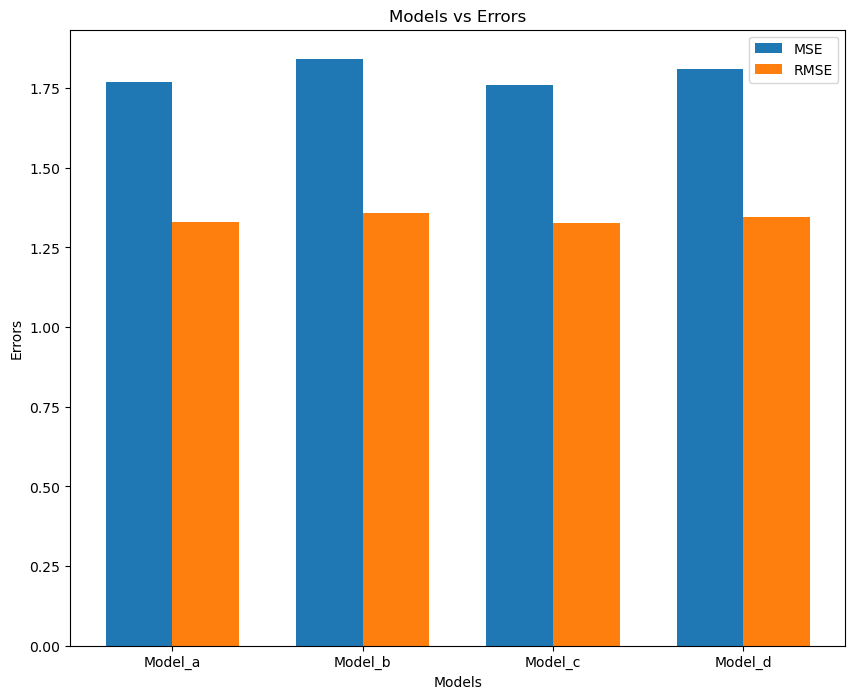

In [96]:
#Visualization of the results
labels = ['Model_a','Model_b','Model_c','Model_d']
mse_data = [mse_mod_a,mse_mod_b,mse_mod_c,mse_mod_d]
rmse_data = [rmse_mod_a,rmse_mod_b,rmse_mod_c,rmse_mod_d]

plt.figure(figsize=(10, 8))
index = np.arange(len(labels))
plt.bar(index, mse_data, 0.35, label="MSE")
plt.bar(index + 0.35, rmse_data, 0.35, label="RMSE")

plt.xlabel("Models")
plt.ylabel("Errors")
plt.title("Models vs Errors")
plt.xticks(index + 0.35 / 2, labels)
plt.legend()

plt.show()

# Analysis of the plot

From the above bar plot, it can be seen that the models trained with the most correlated data (Model_a and Model_c) have low error values compared to the models trained with least correlated data (Model_b, Model_d). 

**Best performing Model**: Model C

**Worst performing Model**: Model B

**Highest MSE**: Approximately 1.80 (Model B)

**Highest RMSE**: Approximately 1.35 (Model B)

**Lowest MSE**: Approximately 1.72 (Model C)

**Lowest RMSE**: Approximately 1.30 (Model C)

While it was expected that model with most correlated features would perform well, the differences in error values between models isn't significant. This could mean many things such as:

1. The choice of categorical encoding for certain features wasn't the best
2. The features selected for predicting rating might not have been enough. Additional features could have possibly given us a  better result
3. The selected features might not have been the best choice for predicting ratings. However, the dataset lacks other informative columns with possible relationship with ratings. 
4. The data sample size might not have been enough for making better predictions


